## U.S. Unemployment Rate Change by Metropolitan Statistical Area (MSA)

Created by Brian Dew (brianwdew@gmail.com), March 27, 2017.

The goal of this notebook is to create a U.S. map that shows how unemployment rates are changing by city. 

https://download.bls.gov/pub/time.series/la/la.areamaps (list of codes of all local areas)

http://gis.stackexchange.com/questions/198530/plotting-us-cities-on-a-map-with-matplotlib-and-basemap

http://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states

This folder on GitHub (https://github.com/bdecon/Python/Unemp_Map) contains four files needed to make the code work:
1. MSA.csv - contains the names, codes, and locations for metropolitan statistical areas
2. st99_d00.dbf - one of the files used for drawing state shapes
3. st99_d00.shp - main state shapefile
4. st99_d00.shx - final file for drawing state shapes

### Obtaining the city locations and their unemployment rate change values

First, we load the pandas and matplotlib libraries that will allow us to work with data and map it. The second step is to load both the data that do not change (city names, codes, and locations) and the data that do change (BLS unemployment rate estimates). The third step is to combine the two datasets.

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap as Basemap
# Settings for the map
m = Basemap(llcrnrlon=-121, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95)

In [2]:
# CSV file contains city names, their BLS codes (Metropolitan 
# MTAs/NECTAs only), and their latitude and longitude
MSA = pd.read_csv('MSA.csv')

# BLS flat file contains the unemployment rate by month since 2015
url = 'https://download.bls.gov/pub/time.series/la/la.data.0.CurrentU15-19'
df = pd.read_table(url, sep='\s+')

In [3]:
# Take only the unemployment data for MSAs and monthly series 
# (M13 is annual average)
df = pd.DataFrame(df[df['series_id'].isin(MSA['fullcode']) 
                 & ~df['period'].isin(['M13'])])

# Clean up the date to convert it to pandas datetime
df.loc[:,'month'] = df['period'].replace(regex=True, 
                                         to_replace=r'M', 
                                         value=r'')
df.loc[:,'day'] = 1
df.loc[:,'date'] = pd.to_datetime(df[['year', 'month', 'day']])

# Calculate one year change in unemployment rate for each MSA
df = df.set_index(['series_id','date'])['value'].diff(
    periods=12).dropna()

# Keep only the latest value for each MSA
df = df.reset_index().groupby(['series_id']).tail(1)
df.rename(columns={'series_id':'fullcode'}, inplace=True)

# Take the date for use in chart title
date = df['date'].iloc[0].strftime('%B %Y')

# Combine the two datasets and show 2 rows to verify 
unemp_list = df.merge(MSA, on='fullcode')

In [4]:
# From the change in unemployment rate, mark increases red, decreases green,
#   no change is gray. The size of the circle to draw is the absolute value 
#   of the change times 8. Alaska and Hawaii are shifted (Alaska is also 
#   scaled down) and locations are otherwise mapped.

for index, row in unemp_list.iterrows():
    x, y = m(row['longitude'],row['latitude'])
    if row['value'] > 0:
        unemp_list.loc[index,'color'] = 'Red'
        unemp_list.loc[index,'size'] = abs(row['value'])*8
    if row['value'] < 0:
        unemp_list.loc[index,'color'] = 'Limegreen'
        unemp_list.loc[index,'size'] = abs(row['value'])*8
    if row['value'] == 0:
        unemp_list.loc[index,'color'] = 'Lightgray'
        unemp_list.loc[index,'size'] = 0.5   # Just to mark location
    if row['fullname'][-2:] == 'AK':
        unemp_list.loc[index,'x'] = 0.35 * x + 1100000
        unemp_list.loc[index,'y'] = 0.35 * y - 1300000
    elif row['fullname'][-2:] == 'HI':
        unemp_list.loc[index,'x'] = x + 5200000
        unemp_list.loc[index,'y'] = y - 1400000
    else:
        unemp_list.loc[index,'x'] = x
        unemp_list.loc[index,'y'] = y

### Mapping the values

The second part involves mapping the data. There are three map/shape files located in the same folder as the ipynb, which are read by the basemap package as U.S. states. To include Alaska and Hawaii, the values for these two states are transformed. Alaska is scaled down to 35 percent of it's actual size and moved, with Hawaii to fit underneath the continental U.S.

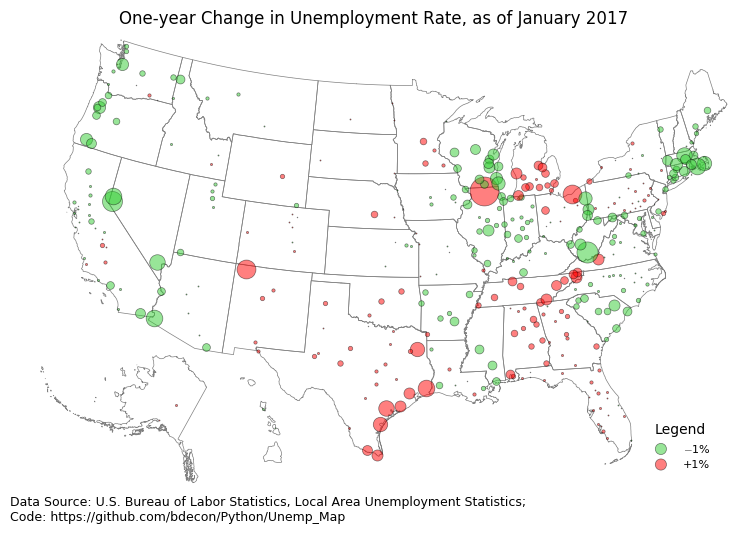

In [5]:
plt.gcf()
plt.figure(figsize=(12,6))

# Read the shapefile contained in the same folder (and the two related files)
m.readshapefile('st99_d00', 'states', drawbounds=True, color='grey')

ax = plt.gca()

# Thanks to stackexchange for this solution to include Alaska and Hawaii
for i, shapedict in enumerate(m.states_info):
    # Translate the noncontiguous states:
    if shapedict['NAME'] in ['Alaska', 'Hawaii']:
        seg = m.states[int(shapedict['SHAPENUM'] - 1)]
        # Only include the 8 main islands of Hawaii 
        if shapedict['NAME'] == 'Hawaii' and float(shapedict['AREA']) > 0.005:
            seg = list(map(lambda (x,y): (x + 5200000, y-1400000), seg))
        # Alaska is large. Rescale it.
        elif shapedict['NAME'] == 'Alaska':
            seg = list(map(lambda (x,y): (0.35*x + 1100000, 0.35*y-1300000), seg))
        poly = Polygon(seg, facecolor='white', edgecolor='gray', linewidth=.5)
        ax.add_patch(poly)

# Plot each location, value, and color as identified in the previous section        
for index, row in unemp_list.iterrows():
    m.plot(row['x'], row['y'], marker='o',color=row['color'], alpha=0.5, 
           markersize = row['size'])

ax.axis('off')    # Remove default border
plt.title('One-year Change in Unemployment Rate, as of ' + date)
plt.annotate('Data Source: U.S. Bureau of Labor Statistics, Local Area Unemployment Statistics; \n' \
             'Code: https://github.com/bdecon/Python/Unemp_Map',
             (0,0), (0, 0), fontsize=9, xycoords='axes fraction', textcoords='offset points', va='top')

# Legend 
l1 = plt.scatter([],[], marker='o',color='Limegreen', alpha=0.5, 
              s = 65, edgecolors='Black', linewidth=.5)
l2 = plt.scatter([],[], marker='o',color='Red', alpha=0.5, 
              s = 65, edgecolors='Black', linewidth=.5)

labels = ["$-$1%", "+1%"]

leg = plt.legend([l1, l2], labels, ncol=1, frameon=False, fontsize=8,
handlelength=2, loc = 4, borderpad = 1.8,
handletextpad=1, title='Legend', scatterpoints = 1)

plt.show()